# Titanic survival prediction

### Author: Adriana Bukala

Today, we will take care of a classification problem - we will predict survival chances for Titanic passengers. We will work on data from this source: https://www.kaggle.com/c/titanic/data

Let's start with some explanatory data analysis of our dataset.

### EDA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

X_train = pd.read_csv('train.csv', index_col=0)
X_test = pd.read_csv('test.csv', index_col=0)
y_test = pd.read_csv('survival.csv', index_col=0)

print(f'Number of observations in the train set: {len(X_train)}')
print(f'Number of observations in the test set: {len(X_test)}')
X_train.head()

Number of observations in the train set: 891
Number of observations in the test set: 418


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Our data has following columns:
* PassengerId - identificator (we use it as an index column),
* Survived - indicating whether a passenger survived,
* Pclass - passenger class, values from 1 to 3, where 1 is indicating 1st class, approximating upper socio-economic status,
* Name - passenger name,
* Sex,
* Age,
* SibSp - number of siblings / spouses aboard the Titanic,
* Parch - number of parents / children aboard the Titanic,
* Ticket - ticket number,
* Fare - ticket price,
* Cabin - cabin number,
* Embarked - port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

Now, we need to do some data preprocessing:
1. Delete 'Survived' (target/y columns) from X datasets,
2. Fill nan values with string 'None' for 'Cabin' column (will make label encoding easier),
3. Get rid of 'Name', 'Ticket' and 'Embarked' columns. First two are just different kind of ids, third should make no difference.
4. Get rid of rows with no age or no fare.

In [2]:
y_train = X_train['Survived'].copy()
X_train = X_train.loc[:, X_train.columns != 'Survived'].copy()

X_test = X_test.loc[:, X_test.columns != 'Survived'].copy()

X_train['Cabin'] = X_train['Cabin'].fillna('None')
X_test['Cabin'] = X_test['Cabin'].fillna('None')


X_train = X_train.drop(columns=['Ticket', 'Name', 'Embarked'])
X_train = X_train.dropna(axis=0, subset=['Age', 'Fare'], how='any')

X_test = X_test.drop(columns=['Ticket', 'Name', 'Embarked'])
X_test = X_test.dropna(axis=0, subset=['Age', 'Fare'], how='any')

y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

print(f'Number of observations in the train set after preprocessing: {len(X_train)}')
print(f'Number of observations in the test set after preprocessing: {len(X_test)}')

Number of observations in the train set after preprocessing: 714
Number of observations in the test set after preprocessing: 331


Now we will visualize our **training data**.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


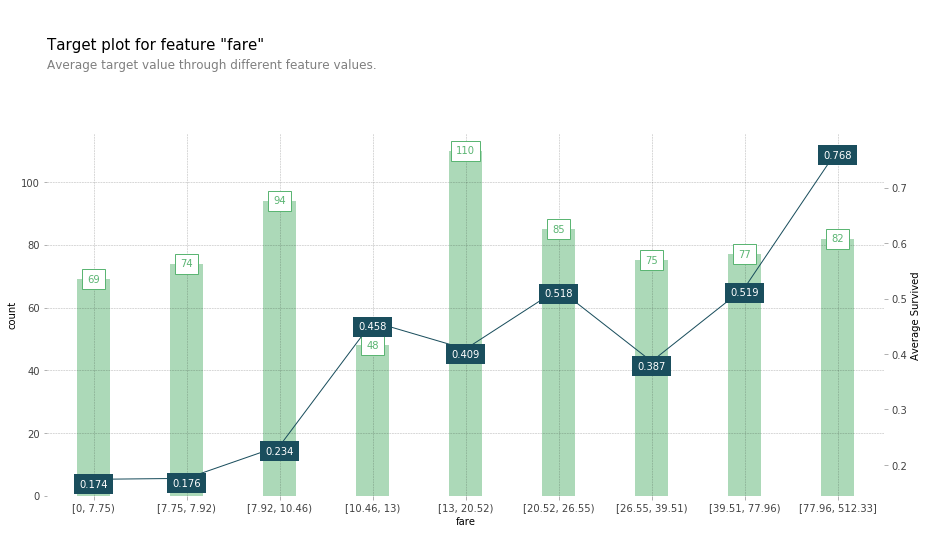

In [3]:
from pdpbox import pdp, info_plots

X_train_full = pd.concat([X_train, y_train], axis=1)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X_train_full['Sex'] = le.fit_transform(X_train_full['Sex'])
X_train_full['Cabin'] = le.fit_transform(X_train_full['Cabin'])

fig, axes, summary_df = info_plots.target_plot(
    df=X_train_full, feature='Fare', feature_name='fare', target='Survived'
)

We could probably approximate this trend with a linear function. Clearly, passengers, who paid lower fares had much lower chances of survival. However, it is worth noticing that fare column is not enough to estimate survival - for example passengers, who paid between (26.54, 39.50) were on average less likely to survive than ones that paid (10.45, 13)

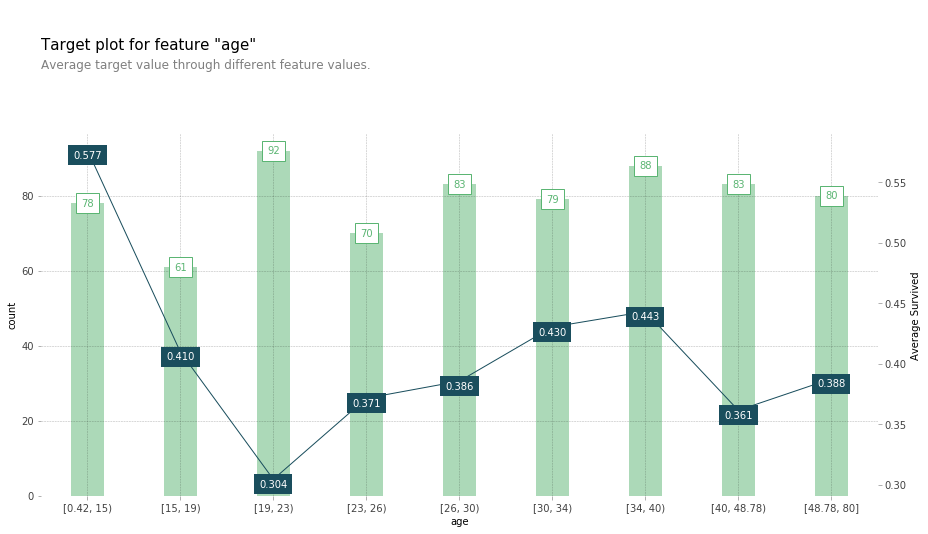

In [4]:
fig, axes, summary_df = info_plots.target_plot(
    df=X_train_full, feature='Age', feature_name='age', target='Survived'
)

As for age, children and adolescents were first to being rescued. For other age groups predictions are comparable.

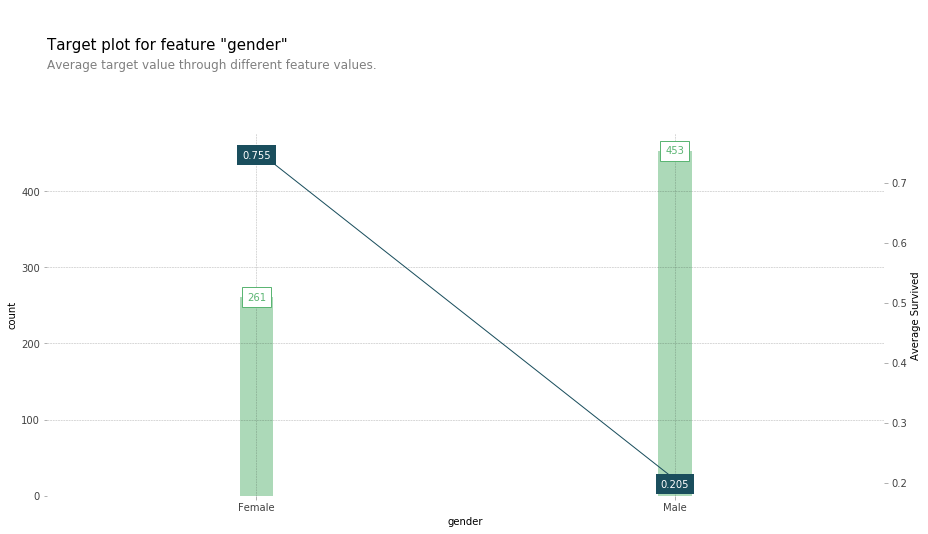

In [5]:
fig, axes, summary_df = info_plots.target_plot(
    df=X_train_full, feature='Sex', feature_name='gender', target='Survived'
)
_ = axes['bar_ax'].set_xticklabels(['Female', 'Male'])

Women were much more likely to survive than men.

### Data preprocessing

Now, we will prepare a pipeline for our future predictors. We have two numerical features - Age and Fare, which we will standardize. As for other, categorical, variables - we will encode them as binary vectors, so-called one-hot vectors.

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_features = ['Age', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['Cabin', 'Sex', 'Pclass', 'SibSp', 'Parch']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

print(preprocessor)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Age', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Cabin', 'Sex', 'Pclass', 'SibSp', 'Parch'])])


### First model - GradientBoosting

We add a predictor to our pipeline - **GradientBoostingClassifier**. Now, we can fit training dataset and check our model's performance.

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import  plot_confusion_matrix, classification_report, accuracy_score

model1 = Pipeline(steps=[('preprocessor', preprocessor), 
                         ('classifier', GradientBoostingClassifier(random_state=256))])
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)

print(model1)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Cabin', 'Sex', 'Pclass',
                                                   'SibSp', 'Parch'])])),
                ('classifier', GradientBoostingClassifier(random_state=256))])


Accuracy: 0.9274924471299094
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       204
           1       0.93      0.87      0.90       127

    accuracy                           0.93       331
   macro avg       0.93      0.92      0.92       331
weighted avg       0.93      0.93      0.93       331



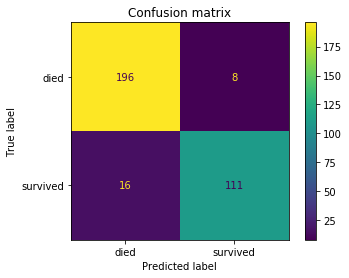

In [8]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

ax = plt.subplot()
ax.set_title('Confusion matrix')
plot_confusion_matrix(model1, X_test, y_test, ax=ax)
ax.xaxis.set_ticklabels(['died', 'survived'])
ax.yaxis.set_ticklabels(['died', 'survived'])
plt.show()

Our model is quite good at predicting, whether someone would survive Titanic, though it's a bit better at recognizing people, who actually died there than at recognizing the survivors.

### Explaining 1st model

Let's understand our model's predictions, shall we? We will use **Ceteris Paribus** plots for that. We need to create an explainer based on our model. As a target probability we choose **probability of survival** (equal to 1 - probability of death as we have only two possibilities).

We'd like to find two observations with different explanations. Subjectively, we choose two middle-aged women:
* first one was a 3rd class passenger, who paid for her ticket only 14.50. She had 47 years and one sibling/spouse aboard. She didn't survive,
* second one was a 1st class passenger, who paid for her ticket 227.53. She had 42 years and no family or partners aboard. She did survive.

In [9]:
from ceteris_paribus.explainer import explain
from ceteris_paribus.plots.plots import plot
from ceteris_paribus.profiles import individual_variable_profile

explainer_gb = explain(model1, X_train.columns, X_train, y_train,
                       predict_function=lambda X: model1.predict_proba(X)[::, 1], label='GradientBoosting')

id1 = 133
id2 = 381

print(f'Woman1:\n{X_train.loc[id1]}\n\n')
print(f'Woman2:\n{X_train.loc[id2]}')

Woman1:
Pclass         3
Sex       female
Age           47
SibSp          1
Parch          0
Fare        14.5
Cabin       None
Name: 133, dtype: object


Woman2:
Pclass          1
Sex        female
Age            42
SibSp           0
Parch           0
Fare      227.525
Cabin        None
Name: 381, dtype: object


We check, how changes in age, fare or passenger class could influence these women's fate.

In [10]:
cp_profile1 = individual_variable_profile(explainer_gb, X_train.loc[id1], 
                                         y=y_train.loc[id1], variables=['Age', 'Fare', 'Pclass'])
cp_profile2 = individual_variable_profile(explainer_gb, X_train.loc[id2], 
                                         y=y_train.loc[id2], variables=['Age', 'Fare', 'Pclass'])

plot(cp_profile1, destination='notebook', color='navy', height=500, width=870)
plot(cp_profile2, destination='notebook', color='rebeccapurple', height=500, width=870)

Our model1 decided that the first woman had around **0.32** chances of survival (what corresponds to binary verdict that she didn't survive). On the other hand, model1 was almost sure (**0.93**) that the second woman would survive. Why? Let's check!

Explanations of explanations:
* **age** - for the first woman age is much more significant variable than for the second one; if she was a child, she would be more likely to survive (which is quite intuitive, because usually children are saved first). For her, chances of survival are decreasing with increased age, with small change of trend at the end. It almost couldn't have gotten worse - there is only one small peak, where probability of survival is lower than for her actual age. **It looks like for a lower-class passenger age was a significant variable. But if someone was a upper-class passenger (at least female one), age didn't matter much**. We can see that on the second plot - even lowest value corresponds to a probability of survival > 0.8!
* **fare** - basically, we are expecting to see a monotonically increasing function, right? But it's much more interesting! **Even if the first woman paid twice much as the second one, she wouldn't have same chances of survival, according to our model1.** Moreover, we can see an upside-down pattern around price of 20 - for woman1 it's a place of decreased probability, for woman2 - leaping increase of it,
* **pclass** - here we have rather compatible results - **if woman2 was a 3rd class passenger, she would have similar probability of survival as woman1, if she paid around 220 for her ticket.**

To sum up:
1. Passenger class and fare are correlated. 1st class/high fare are increasing probability of survival, but increase is larger if they "work" together.
2. Age was important, if you were poor. If you were rich (and female), you would probably survive anyway.
3. These explanations seem stable.

In [11]:
from ceteris_paribus.select_data import select_neighbours

neighbours = select_neighbours(X_train, X_train.iloc[122],
    selected_variables=['Fare', 'Pclass'], 
    n=5)

cp_xgb_ns = individual_variable_profile(explainer_gb, neighbours)


plot(cp_xgb_ns, color='Sex', selected_variables=['Age', 'Fare', 'Pclass'], 
    aggregate_profiles='mean', size_pdps=5, alpha_pdps=0.5, size=2, 
     destination='notebook', height=500, width=870)

These plots are summing up, what we already know - women had higher chances of survival than men. What it is interesting and new, is that decrease in probability for men for second passenger class.

Finally, we look at the global prediction tendencies. **Firstly, we will show survival probabilities estimated from the data itself, then - model1 predictions.**

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


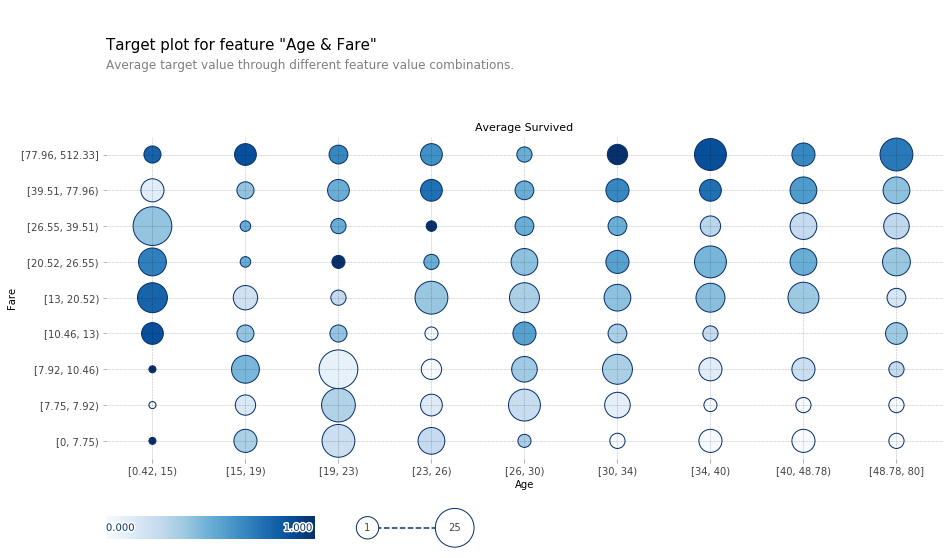

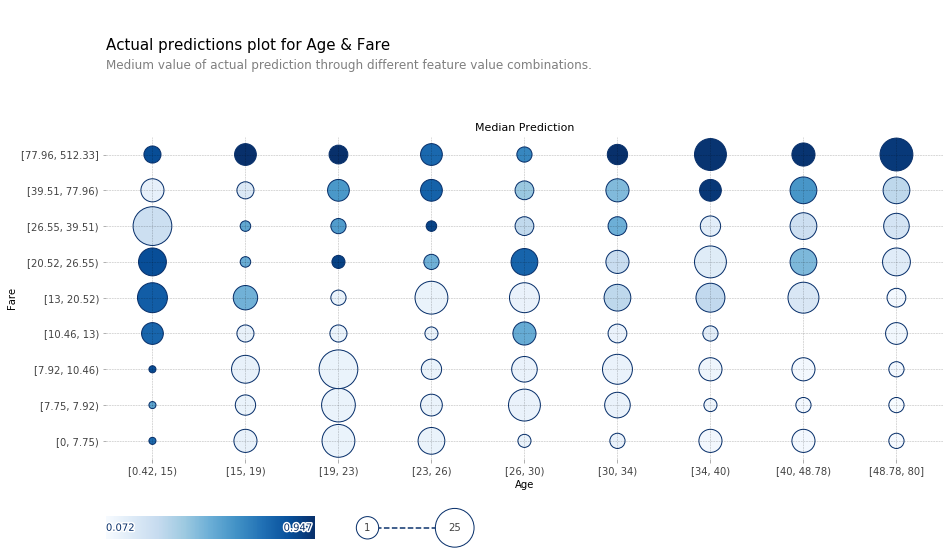

In [12]:
fig, axes, _ = info_plots.target_plot_interact(
    df=X_train_full, features=['Age', 'Fare'], feature_names=['Age', 'Fare'], target='Survived',
)

fig, axes, _ = info_plots.actual_plot_interact(
    model=model1, X=X_train, 
    features=['Age', 'Fare'], feature_names=['Age', 'Fare']
)

Conclusions:
1. Model1 is a bit careful - we see no 0 or 1 probability values.
2. **Model1 reflects the trends in the data rather well**; young people or eldery are more likely to survive than middle-aged ones; rich people are more likely to survive than the poor ones; lower and middle-class adults were in the worst position.
3. **Model1 overestimates the importance of fare** - probability of survival of the richest (top row) is higher for each age group than the actual survival rate.


### Second model - RandomForest

Now, we will train our second tree-based model - **RandomForestClassifier**.

In [13]:
from sklearn.ensemble import RandomForestClassifier

model2 = Pipeline(steps=[('preprocessor', preprocessor), 
                         ('classifier',
                          RandomForestClassifier(random_state=4, max_depth=5))])
model2.fit(X_train, y_train)

y_pred2 = model2.predict(X_test)

print(model2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Cabin', 'Sex', 'Pclass',
                                                   'SibSp', 'Parch'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=5, random_state=4))])


Let's check its performance!

Accuracy: 0.9758308157099698
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       204
           1       1.00      0.94      0.97       127

    accuracy                           0.98       331
   macro avg       0.98      0.97      0.97       331
weighted avg       0.98      0.98      0.98       331



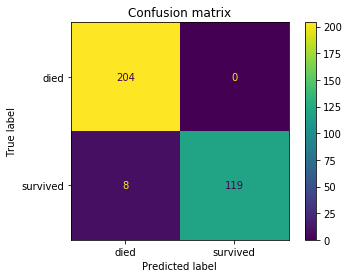

In [14]:
print(f'Accuracy: {accuracy_score(y_test, y_pred2)}')
print(classification_report(y_test, y_pred2))

ax = plt.subplot()
ax.set_title('Confusion matrix')
plot_confusion_matrix(model2, X_test, y_test, ax=ax)
ax.xaxis.set_ticklabels(['died', 'survived'])
ax.yaxis.set_ticklabels(['died', 'survived'])
plt.show()

**Model2 is better than model1 (acc 0.98 vs. 0.93).** Same as previous one, it has some problems when deciding, whether actual survivors would live (bottom left cell of confusion matrix).

### Explaining 2nd model

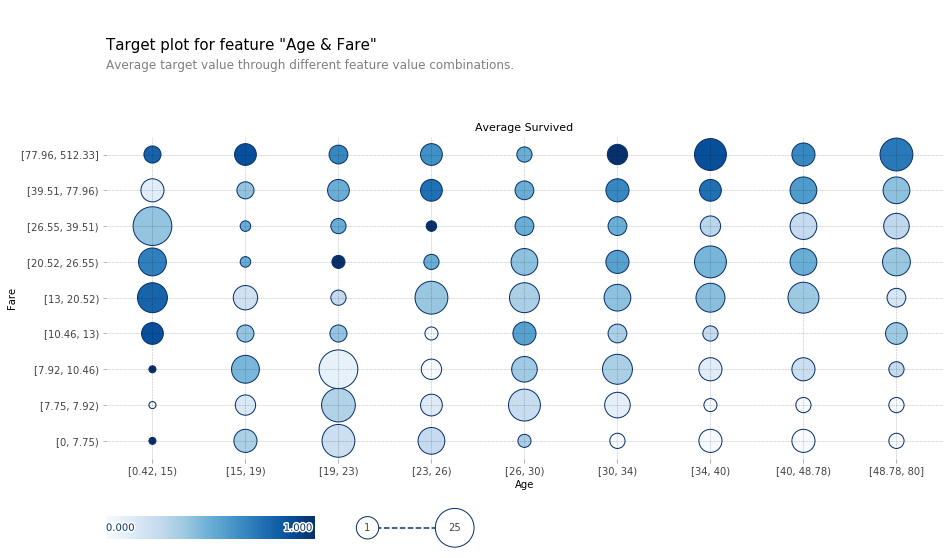

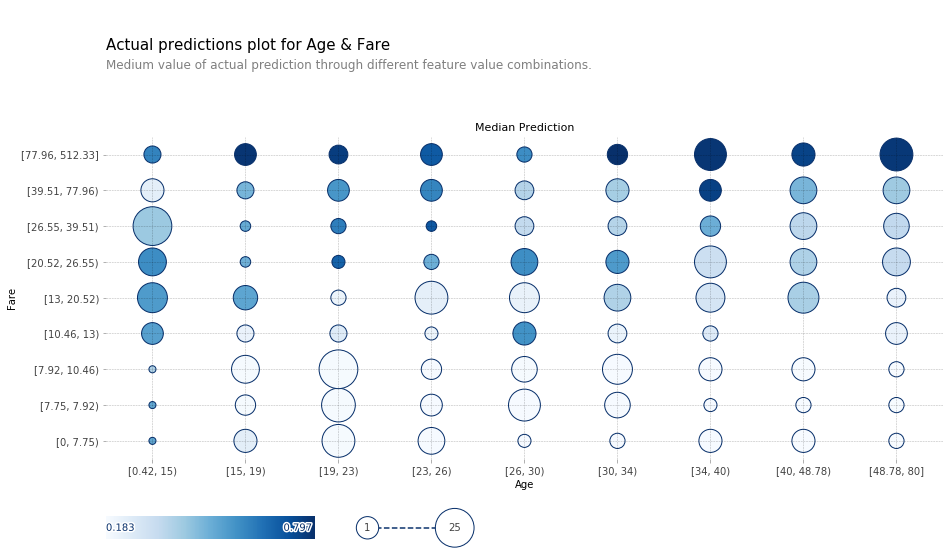

In [15]:
fig, axes, _ = info_plots.target_plot_interact(
    df=X_train_full, features=['Age', 'Fare'], feature_names=['Age', 'Fare'], target='Survived',
)

fig, axes, _ = info_plots.actual_plot_interact(
    model=model2, X=X_train, 
    features=['Age', 'Fare'], feature_names=['Age', 'Fare']
)

**Model2 is even more careful than model1** - we see probability values from 0.18 to 0.8. Once again, we have a good reflection of true survival rate, slightly overestimating the importance of fare.

Finally, we will check some explanations for which our two models had different predictions.

In [16]:
explainer_ab = explain(model2, X_train.columns, X_train, y_train,
                       predict_function=lambda X: model2.predict_proba(X)[::, 1], label='RandomForest')

for i in np.where(y_pred != y_pred2)[0][:2]:
    cp_profile1 = individual_variable_profile(explainer_gb, X_test.iloc[i], 
                                             y=y_test.iloc[i], variables=['Age', 'Fare', 'Pclass'])
    cp_profile2 = individual_variable_profile(explainer_ab, X_test.iloc[i], 
                                             y=y_test.iloc[i], variables=['Age', 'Fare', 'Pclass'])

    plot(cp_profile1, cp_profile2, destination='notebook', height=500, width=870)

We see two young, female passengers of 3rd class, who both survived. **All four predictions (two observations & two models) were close to 0.5, which is an equivalent of guessing.** In first case, model2 was correct, in second one - model1. **However, we see almost completely different variable profiles on those plots between two models.** Model1, GradientBoosting, was likely to change its prediction, if women were younger or if they paid more for their tickets. Model2, RandomForest, would increase probability of survival the most, if women were 1st class passengers, age or fare didn't matter that much. That's concerning, because as we all now, female children had rather high chances of survival. It is even more concerning, if we remember that model2 was better at prediction (it had accuracy of 0.98 on test set). What could go wrong? **For our second model, we set a maximum tree depth equal to 5, so it's possible that model2 actually is a better predictor, even though it's not so sure of its decisions.** We will look at two more observations to be sure.

In [17]:
for i in np.where(y_pred != y_pred2)[0][3:5]:
    cp_profile1 = individual_variable_profile(explainer_gb, X_test.iloc[i], 
                                             y=y_test.iloc[i], variables=['Age', 'Fare', 'Pclass'])
    cp_profile2 = individual_variable_profile(explainer_ab, X_test.iloc[i], 
                                             y=y_test.iloc[i], variables=['Age', 'Fare', 'Pclass'])

    plot(cp_profile1, cp_profile2, destination='notebook', height=500, width=870)

We have a similar situation - both predictions are close to 0.5, but this time only model2 was correct. Once again, variable profiles generated based on model2 are more stable. Maybe it shouldn't surprise us, as this model has predictions of probability from 0.18 to "only" 0.8 and right now we are looking at some problematic cases.

# Appendix (code)

Today, we will take care of a classification problem - we will predict survival chances for Titanic passengers. We start with loading some basics packages.

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### EDA

Then we load the data from this source: https://www.kaggle.com/c/titanic/data

In [19]:
X_train = pd.read_csv('train.csv', index_col=0)
X_test = pd.read_csv('test.csv', index_col=0)
y_test = pd.read_csv('survival.csv', index_col=0)

In [20]:
print(X_train.columns)

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')


Our data has following columns:
* PassengerId - identificator (we use it as an index column),
* Survived - indicating whether a passenger survived,
* Pclass - passenger class, values from 1 to 3, where 1 is indicating 1st class, approximating upper socio-economic status,
* Name - passenger name,
* Sex,
* Age,
* SibSp - number of siblings / spouses aboard the Titanic,
* Parch - number of parents / children aboard the Titanic,
* Ticket - ticket number,
* Fare - ticket price,
* Cabin - cabin number,
* Embarked - port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

Now, we need to do some data preprocessing:
1. Delete 'Survived' (target/y columns) from X datasets,
2. Fill nan values with string 'None' for 'Cabin' column (will make label encoding easier),
3. Get rid of 'Name', 'Ticket' and 'Embarked' columns. First two are just different ids, third should make no difference.
4. Get rid of rows with no age or no fare.

In [21]:
y_train = X_train['Survived'].copy()
X_train = X_train.loc[:, X_train.columns != 'Survived'].copy()

X_test = X_test.loc[:, X_test.columns != 'Survived'].copy()

In [22]:
X_train['Cabin'] = X_train['Cabin'].fillna('None')
X_test['Cabin'] = X_test['Cabin'].fillna('None')

In [23]:
X_train = X_train.drop(columns=['Ticket', 'Name', 'Embarked'])
print(len(X_train))
X_train = X_train.dropna(axis=0, subset=['Age', 'Fare'], how='any')
print(len(X_train), '\n')

X_test = X_test.drop(columns=['Ticket', 'Name', 'Embarked'])
print(len(X_test))
X_test = X_test.dropna(axis=0, subset=['Age', 'Fare'], how='any')
print(len(X_test))

891
714 

418
331


In [24]:
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

Because of pdpbox implementation, we need to concatenate X and y data in order to make some visualizations.

In [25]:
from pdpbox import pdp, info_plots

In [26]:
X_train_full = pd.concat([X_train, y_train], axis=1)

In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X_train_full['Sex'] = le.fit_transform(X_train_full['Sex'])
X_train_full['Cabin'] = le.fit_transform(X_train_full['Cabin'])

And now we can make some visualizations of our train data.

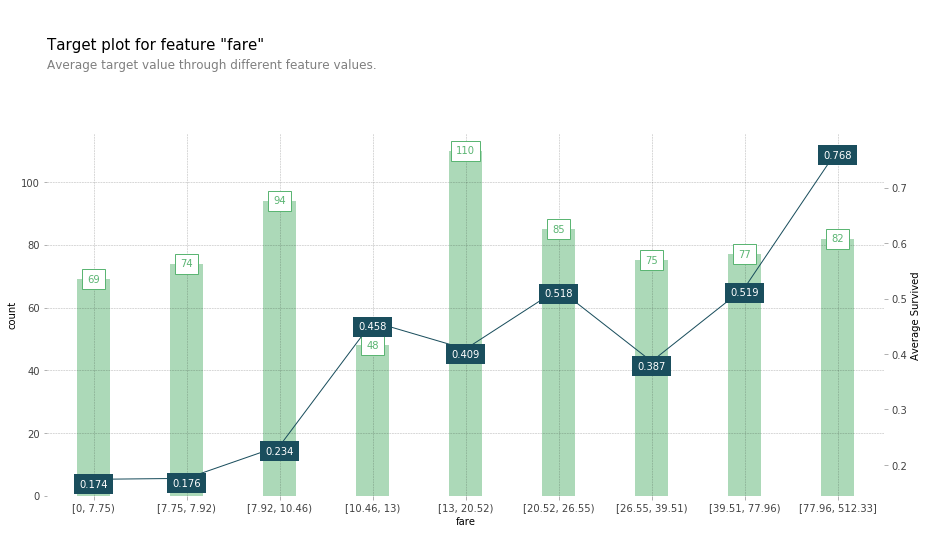

In [28]:
fig, axes, summary_df = info_plots.target_plot(
    df=X_train_full, feature='Fare', feature_name='fare', target='Survived'
)

We could probably approximate this trend with a linear function. Clearly, passengers, who paid lower fares had much lower chances of survival. However, it is worth noticing that fare column is not enough to estimate survival - for example passengers, who paid between (26.54, 39.50) were on average less likely to survive than ones that paid (10.45, 13)

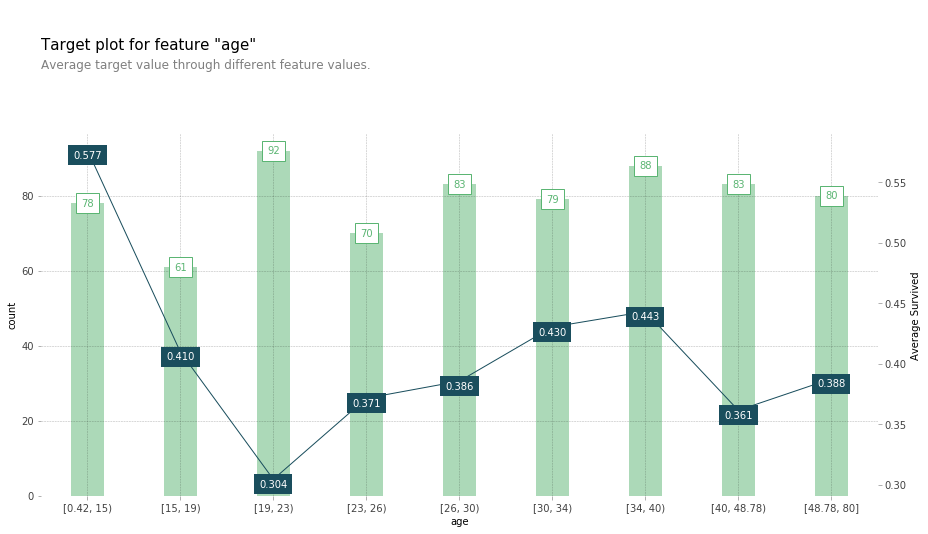

In [29]:
fig, axes, summary_df = info_plots.target_plot(
    df=X_train_full, feature='Age', feature_name='age', target='Survived'
)

As for age, children and adolescents were first to being rescued. For other age groups predictions are comparable.

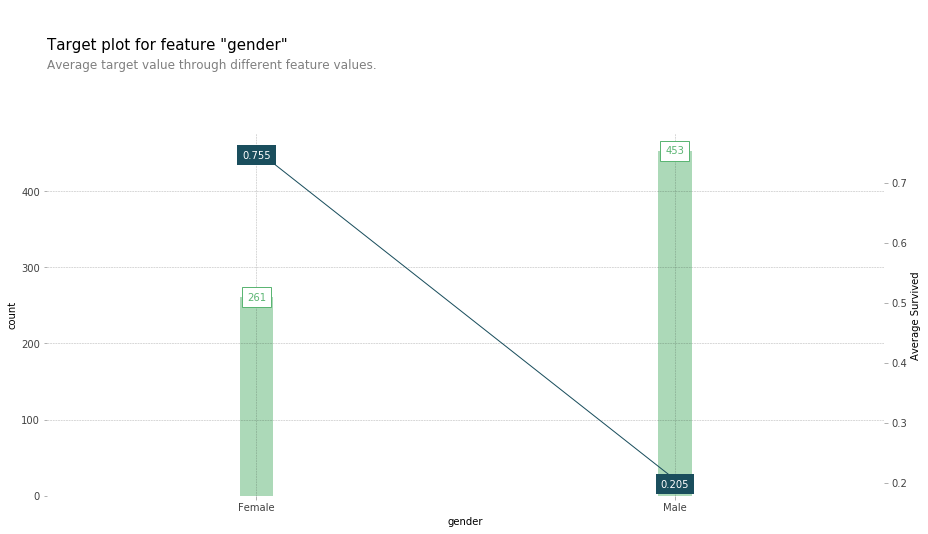

In [30]:
fig, axes, summary_df = info_plots.target_plot(
    df=X_train_full, feature='Sex', feature_name='gender', target='Survived'
)
_ = axes['bar_ax'].set_xticklabels(['Female', 'Male'])

Women were much more likely to survive than men.

### Data preprocessing

Now, we will prepare a pipeline for our future predictors. 

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

We have two numerical features - Age and Fare, which we will standardize. As for other, categorical, variables - we will encode them as binary vectors, so-called one-hot vectors.

In [32]:
numeric_features = ['Age', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['Cabin', 'Sex', 'Pclass', 'SibSp', 'Parch']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

### First model - GradientBoosting

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import  plot_confusion_matrix, classification_report, accuracy_score

We add a predictor to our pipeline - **GradientBoostingClassifier**. Now, we can fit training dataset and check our model's performance.

In [34]:
model1 = Pipeline(steps=[('preprocessor', preprocessor), 
                         ('classifier', GradientBoostingClassifier(random_state=256))])
model1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Cabin', 'Sex', 'Pclass',
                                                   'SibSp', 'Parch'])])),
                ('classifier', GradientBoostingClassifier(random_state=256))])

In [35]:
y_pred = model1.predict(X_test)

In [36]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.9274924471299094
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       204
           1       0.93      0.87      0.90       127

    accuracy                           0.93       331
   macro avg       0.93      0.92      0.92       331
weighted avg       0.93      0.93      0.93       331



Our model is quite good at predicting, whether someone would survive Titanic, though it's a bit better at recognizing people, who actually died there than survivors.

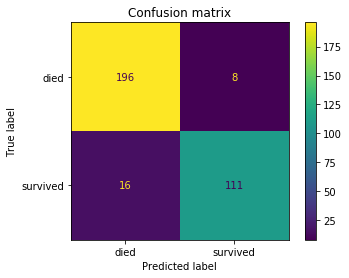

In [37]:
ax = plt.subplot()
ax.set_title('Confusion matrix')
plot_confusion_matrix(model1, X_test, y_test, ax=ax)
ax.xaxis.set_ticklabels(['died', 'survived'])
ax.yaxis.set_ticklabels(['died', 'survived'])
plt.show()

### Explaining 1st model

Let's understand our model's predictions, shall we? We will use **Ceteris Paribus** plots for that.

In [38]:
from ceteris_paribus.explainer import explain
from ceteris_paribus.plots.plots import plot
from ceteris_paribus.profiles import individual_variable_profile

We need to create an explainer based on our model. As a target probability we choose **probability of survival** (equal to 1 - probability of death as we have only two possibilities).

In [39]:
explainer_gb = explain(model1, X_train.columns, X_train, y_train,
                       predict_function=lambda X: model1.predict_proba(X)[::, 1], label='GradientBoosting')

We'd like to find two observations with different explanations. Subjectively, we choose two middle-aged women:
* first one was a 3rd class passenger, who paid for her ticket only 14.50. She had 47 years and one sibling/spouse aboard. She didn't survive,
* second one was a 1st class passenger, who paid for her ticket 227.53. She had 42 years and no family or partners aboard. She did survive.

In [40]:
X_train[(X_train['Fare'] > 10) & (X_train['Fare'] < 20) & (X_train['Age'] > 30) & (X_train['Age'] < 50)][:10]

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
PassengerId,,,,,,,
19,3,female,31.0,1,0,18.00,None
22,2,male,34.0,0,0,13.00,D56
71,2,male,32.0,0,0,10.50,None
86,3,female,33.0,3,0,15.85,None
124,2,female,32.5,0,0,13.00,E101
133,3,female,47.0,1,0,14.50,None
150,2,male,42.0,0,0,13.00,None
154,3,male,40.5,0,2,14.50,None
161,3,male,44.0,0,1,16.10,None


In [41]:
id1 = 133

In [42]:
X_train[(X_train['Fare'] > 200) & (X_train['Fare'] < 400) & (X_train['Age'] > 30) & (X_train['Age'] < 50)]

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
PassengerId,,,,,,,
381,1,female,42.0,0,0,227.5250,None
717,1,female,38.0,0,0,227.5250,C45
780,1,female,43.0,0,1,211.3375,B3


In [43]:
id2 = 381

We check, how changes in age, fare or passenger class could influence these women's fate.

In [44]:
cp_profile1 = individual_variable_profile(explainer_gb, X_train.loc[id1], 
                                         y=y_train.loc[id1], variables=['Age', 'Fare', 'Pclass'])
cp_profile2 = individual_variable_profile(explainer_gb, X_train.loc[id2], 
                                         y=y_train.loc[id2], variables=['Age', 'Fare', 'Pclass'])

plot(cp_profile1, destination='notebook', color='navy', height=500, width=870)
plot(cp_profile2, destination='notebook', color='rebeccapurple', height=500, width=870)

Our model1 decided that the first woman had around **0.32** chances of survival (what corresponds to binary verdict that she didn't survive). On the other hand, model1 was almost sure (**0.93**) that the second woman would survive. Why? Let's check!

Explanations of explanations:
* **age** - for the first woman age is much more significant variable than for the second one; if she was a child, she would be more likely to survive (which is quite intuitive, because usually children are saved first). For her, chances of survival are decreasing with increased age, with small change of trend at the end. It almost couldn't have gotten worse - there is only one small peak, where probability of survival is lower than for her actual age. **It looks like for a lower-class passenger age was a significant variable. But if someone was a upper-class passenger (at least female one), age didn't matter much**. We can see that on the second plot - even lowest value corresponds to a probability of survival > 0.8!
* **fare** - basically, we are expecting to see a monotonically increasing function, right? But it's much more interesting! **Even if the first woman paid twice much as the second one, she wouldn't have same chances of survival, according to our model1.** Moreover, we can see an upside-down pattern around price of 20 - for woman1 it's a place of decreased probability, for woman2 - leaping increase of it,
* **pclass** - here we have rather compatible results - **if woman2 was a 3rd class passenger, she would have similar probability of survival as woman1, if she paid around 220 for her ticket.**

To sum up:
1. Passenger class and fare are correlated. 1st class/high fare are increasing probability of survival, but increase is larger if they "work" together.
2. Age was important, if you were poor. If you were rich (and female), you would probably survive anyway.
3. These explanations seem stable.

In [45]:
from ceteris_paribus.select_data import select_neighbours

In [46]:
neighbours = select_neighbours(X_train, X_train.iloc[122],
    selected_variables=['Fare', 'Pclass'], 
    n=5)

cp_xgb_ns = individual_variable_profile(explainer_gb, neighbours)


plot(cp_xgb_ns, color='Sex', selected_variables=['Age', 'Fare', 'Pclass'], 
    aggregate_profiles='mean', size_pdps=5, alpha_pdps=0.5, size=2, 
     destination='notebook', height=500, width=870)

These plots are summing up, what we already know - women had higher chances of survival than men. What it is interesting and new, is that decrease in probability for men for second passenger class.

Finally, we look at the global prediction tendencies. **Firstly, we will show survival probabilities estimated from the data itself, then - model1 predictions.**

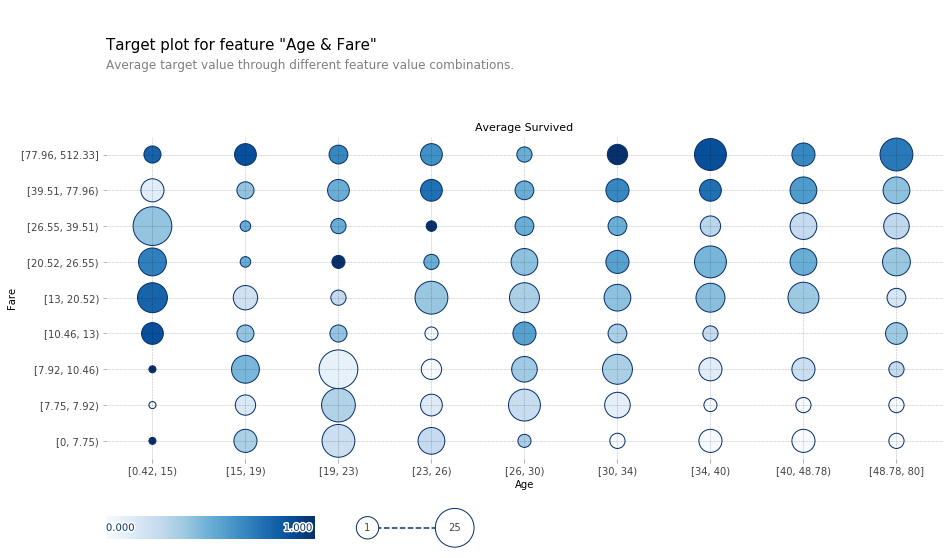

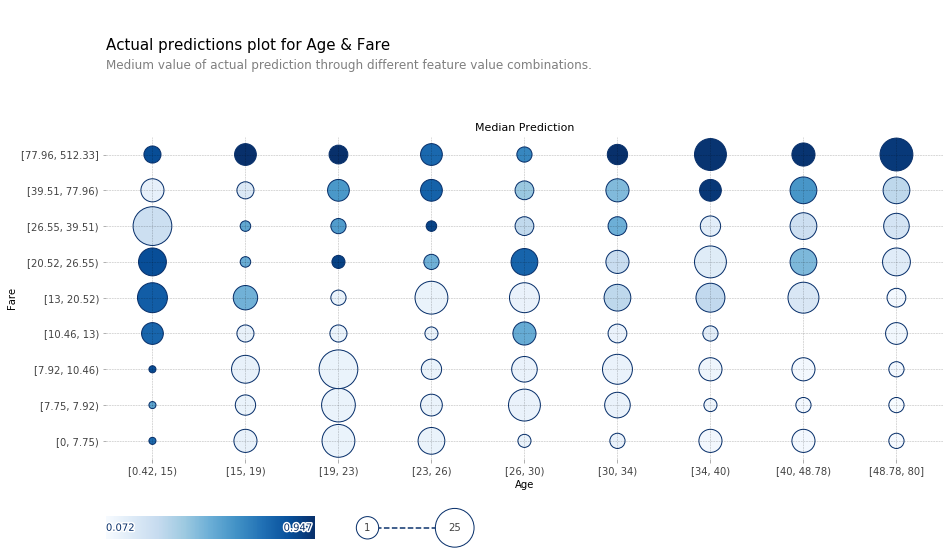

In [47]:
fig, axes, _ = info_plots.target_plot_interact(
    df=X_train_full, features=['Age', 'Fare'], feature_names=['Age', 'Fare'], target='Survived',
)

fig, axes, _ = info_plots.actual_plot_interact(
    model=model1, X=X_train, 
    features=['Age', 'Fare'], feature_names=['Age', 'Fare']
)

Conclusions:
1. Model1 is a bit careful - we see no 0 or 1 probability values.
2. **Model1 reflects the trends in the data rather well**; young people or eldery are more likely to survive than middle-aged ones; rich people are more likely to survive than the poor ones; lower and middle-class adults were in the worst position.
3. **Model1 overestimates the importance of fare** - probability of survival of the richest (top row) is higher for each age group than the actual survival rate.

### Second model - RandomForest

Now, we will train our second tree-based model - RandomForestClassifier.

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
model2 = Pipeline(steps=[('preprocessor', preprocessor), 
                         ('classifier',
                          RandomForestClassifier(random_state=4, max_depth=5))])
model2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Cabin', 'Sex', 'Pclass',
                                                   'SibSp', 'Parch'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=5, random_state=4))])

In [50]:
y_pred2 = model2.predict(X_test)

In [51]:
print(f'Accuracy: {accuracy_score(y_test, y_pred2)}')
print(classification_report(y_test, y_pred2))

Accuracy: 0.9758308157099698
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       204
           1       1.00      0.94      0.97       127

    accuracy                           0.98       331
   macro avg       0.98      0.97      0.97       331
weighted avg       0.98      0.98      0.98       331



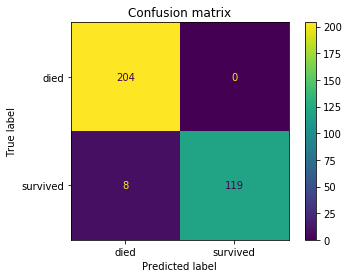

In [52]:
ax = plt.subplot()
ax.set_title('Confusion matrix')
plot_confusion_matrix(model2, X_test, y_test, ax=ax)
ax.xaxis.set_ticklabels(['died', 'survived'])
ax.yaxis.set_ticklabels(['died', 'survived'])
plt.show()

**Model2 is better than model1 (acc 0.98 vs. 0.93).** Same as previous one, it has some problems when deciding, whether actual survivors would live (bottom left cell of confusion matrix).

### Explaining 2nd model

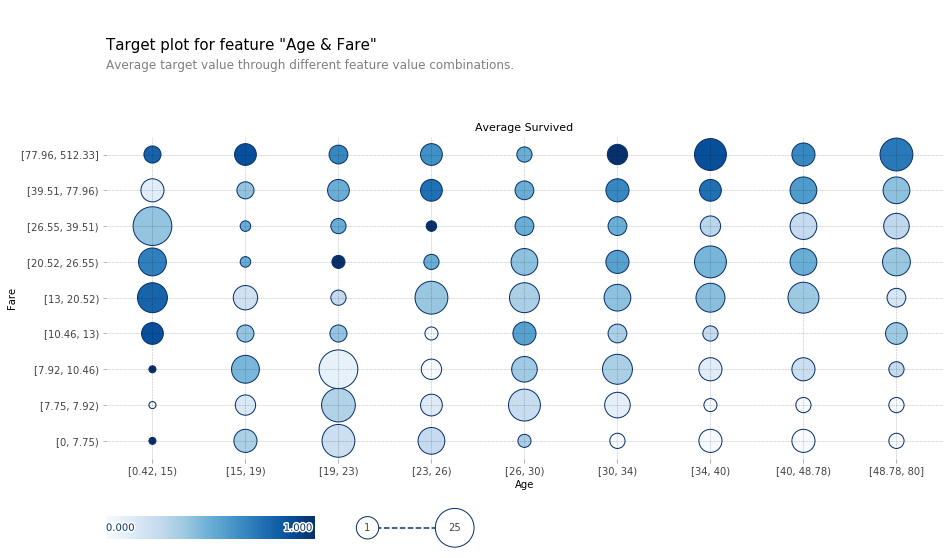

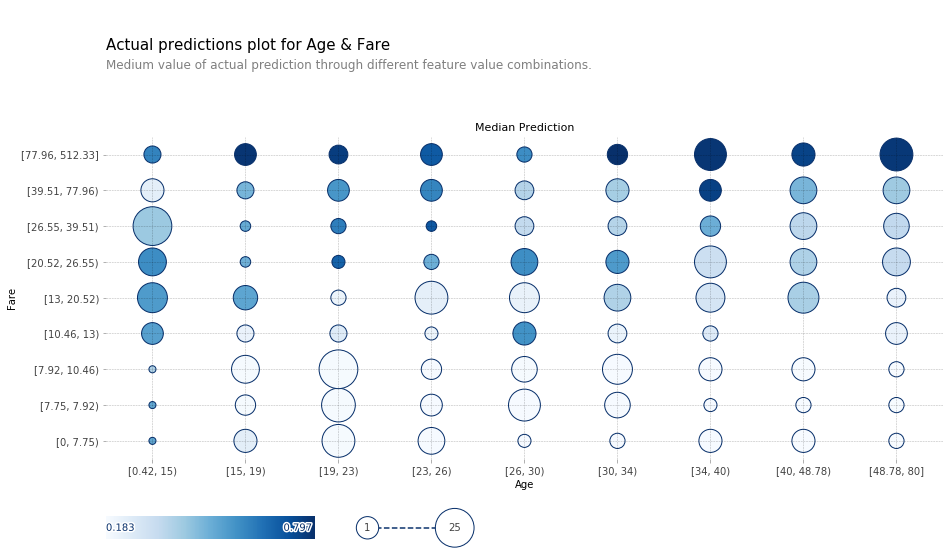

In [53]:
fig, axes, _ = info_plots.target_plot_interact(
    df=X_train_full, features=['Age', 'Fare'], feature_names=['Age', 'Fare'], target='Survived',
)

fig, axes, _ = info_plots.actual_plot_interact(
    model=model2, X=X_train, 
    features=['Age', 'Fare'], feature_names=['Age', 'Fare']
)

**Model2 is even more careful than model1** - we see probability values from 0.18 to 0.8. Once again, we have a good reflection of true survival rate, slightly overestimating the importance of fare.

Finally, we will check some explanations for which our two models had different predictions.

In [54]:
explainer_ab = explain(model2, X_train.columns, X_train, y_train,
                       predict_function=lambda X: model2.predict_proba(X)[::, 1], label='RandomForest')

In [55]:
for i in np.where(y_pred != y_pred2)[0][:2]:
    cp_profile1 = individual_variable_profile(explainer_gb, X_test.iloc[i], 
                                             y=y_test.iloc[i], variables=['Age', 'Fare', 'Pclass'])
    cp_profile2 = individual_variable_profile(explainer_ab, X_test.iloc[i], 
                                             y=y_test.iloc[i], variables=['Age', 'Fare', 'Pclass'])

    plot(cp_profile1, cp_profile2, destination='notebook', height=500, width=870)

We see two young, female passengers of 3rd class, who both survived. **All four predictions (two observations & two models) were close to 0.5, which is an equivalent of guessing.** In first case, model2 was correct, in second one - model1. **However, we see almost completely different variable profiles on those plots between two models.** Model1, GradientBoosting, was likely to change its prediction, if women were younger or if they paid more for their tickets. Model2, RandomForest, would increase probability of survival the most, if women were 1st class passengers, age or fare didn't matter that much. That's concerning, because as we all now, female children had rather high chances of survival. It is even more concerning, if we remember that model2 was better at prediction (it had accuracy of 0.98 on test set). What could go wrong? **For our second model, we set a maximum tree depth equal to 5, so it's possible that model2 actually is a better predictor, even though it's not so sure of its decisions.** We will look at two more observations to be sure.

In [56]:
for i in np.where(y_pred != y_pred2)[0][3:5]:
    cp_profile1 = individual_variable_profile(explainer_gb, X_test.iloc[i], 
                                             y=y_test.iloc[i], variables=['Age', 'Fare', 'Pclass'])
    cp_profile2 = individual_variable_profile(explainer_ab, X_test.iloc[i], 
                                             y=y_test.iloc[i], variables=['Age', 'Fare', 'Pclass'])

    plot(cp_profile1, cp_profile2, destination='notebook', height=500, width=870)

We have a similar situation - both predictions are close to 0.5, but this time only model2 was correct. Once again, variable profiles generated based on model2 are more stable. Maybe it shouldn't surprise us, as this model has predictions of probability from 0.18 to "only" 0.8 and right now we are looking at some problematic cases.